Misma configuracion que fastai_efficientnetb4_v2 la version 2 pero con efficiententb5

CUDA Available:  True
Device:  cuda


c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Javi\anaconda3\envs\TFM\lib\si

c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_

Recommended Learning Rate: 0.001737800776027143


epoch,train_loss,valid_loss,accuracy,time
0,3.062104,2.492501,0.233067,15:18
1,2.630583,2.254146,0.285733,15:17
2,2.329594,2.110437,0.307350,15:15
3,2.061512,1.801360,0.368793,15:06
4,1.804326,1.638325,0.380846,15:00
5,1.652249,1.510983,0.396568,15:34
6,1.657310,1.412521,0.427224,14:58
7,1.499610,1.418571,0.421721,15:25
8,1.427773,1.358119,0.453426,14:49
9,1.435856,1.327764,0.442552,15:17


Better model found at epoch 0 with accuracy value: 0.23306694626808167.
Better model found at epoch 1 with accuracy value: 0.28573301434516907.
Better model found at epoch 2 with accuracy value: 0.30734965205192566.
Better model found at epoch 3 with accuracy value: 0.36879339814186096.
Better model found at epoch 4 with accuracy value: 0.3808463215827942.
Better model found at epoch 5 with accuracy value: 0.39656752347946167.
Better model found at epoch 6 with accuracy value: 0.42722389101982117.
Better model found at epoch 8 with accuracy value: 0.45342591404914856.
Better model found at epoch 10 with accuracy value: 0.4716363251209259.
Better model found at epoch 12 with accuracy value: 0.49548014998435974.
Better model found at epoch 15 with accuracy value: 0.5083191394805908.
Better model found at epoch 18 with accuracy value: 0.5195860266685486.
Better model found at epoch 21 with accuracy value: 0.5477531552314758.
Better model found at epoch 25 with accuracy value: 0.5632123947

c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\fastai\learner.py:61: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


TypeError: unsupported format string passed to NoneType.__format__

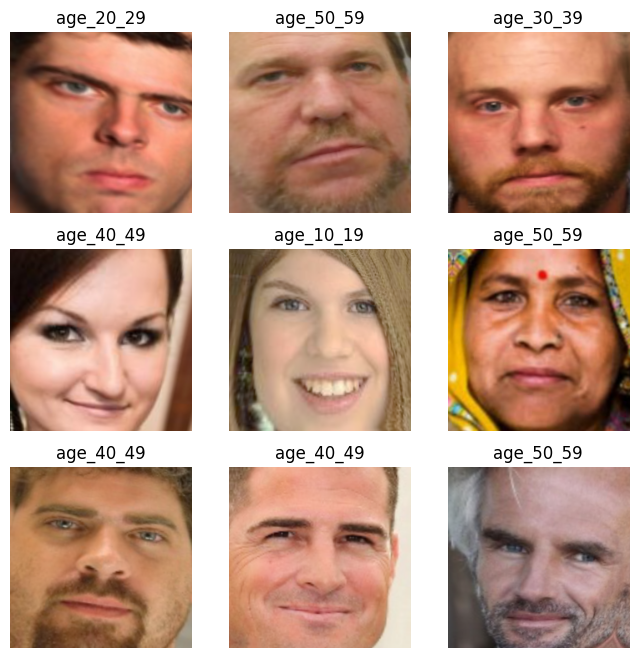

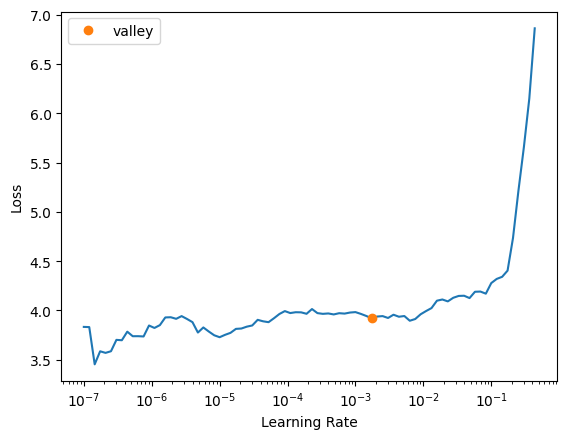

In [1]:
if __name__ == '__main__':
    from fastai.vision.all import *
    from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score
    import matplotlib.pyplot as plt
    from fastai.optimizer import Adam
    from functools import partial
    import torch
    import numpy as np
    import random

    # ===== ESTABLECER SEMILLA PARA REPRODUCIBILIDAD =====
    SEED = 42
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

    torch.cuda.empty_cache()

    # ===== PARÁMETROS =====
    DATASET_PATH = Path('dataset_rangos_10_split')
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 80
    LR = 1e-3

    my_adamw = partial(Adam, 
                       lr=1e-3,
                       wd=1e-2,           # Weight decay
                       decouple_wd=True   # Decoupled = AdamW
                      )

    # ===== CUDA CHECK =====
    print("CUDA Available: ", torch.cuda.is_available())
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device: ", device)

    # ===== DIVISIÓN DE DATOS =====
    splitter = GrandparentSplitter(train_name='train', valid_name='valid')

    # ===== CARGAR DATOS =====
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=splitter,  # División explícita en train/valid
        get_y=parent_label,
        item_tfms=Resize(IMG_SIZE),
        batch_tfms=aug_transforms(
            do_flip=True,
            max_rotate=10.0,
            max_zoom=1.2,
            max_warp=0.2,
            min_scale=0.8
        )
    )

    # ===== DATALOADERS =====
    # Antes de crear los dataloaders, fija la semilla con una función especial
    set_seed(SEED, reproducible=True)

    # Crear los dataloaders
    dls = dblock.dataloaders(DATASET_PATH, bs=BATCH_SIZE, num_workers=0)

    # Mostrar algunas imágenes
    dls.show_batch(max_n=9, figsize=(8, 8))

    # ===== TEST SET =====
    test_files = get_image_files(DATASET_PATH / 'test')
    test_dl = dls.test_dl(test_files)

    # ===== OBTENER PESOS POR CLASE =====
    class_counts = [max(len(list((DATASET_PATH / 'train' / cls).glob('*.jpg'))), 1) for cls in os.listdir(DATASET_PATH / 'train')]

    # Crear pesos inversamente proporcionales al número de imágenes en cada clase
    class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float32)  # Mantén esto en CPU
    class_weights = class_weights.to(device)  # Muévelo a GPU después

    # ===== CREAR EL MODELO =====
    learn = vision_learner(
        dls,
        arch=models.efficientnet_b5,
        metrics=[accuracy],
        loss_func=CrossEntropyLossFlat(weight=class_weights.cpu()),
        opt_func=my_adamw
    ).to_fp16()

    # ===== ENTRENAMIENTO =====
    lr_recommended = learn.lr_find().valley
    print(f"Recommended Learning Rate: {lr_recommended}")

    learn.fit_one_cycle(
        EPOCHS,
        lr_recommended,
        cbs=[
            SaveModelCallback(monitor='accuracy', fname='best_model_b5_v2'),
            EarlyStoppingCallback(monitor='accuracy', patience=10),
            CSVLogger(fname='training_log_b5_v2.csv')
        ]
    )

    # Guardar el último modelo después de entrenar
    learn.save('last_model_b5_v2')

    # ===== EVALUACIÓN EN TEST =====
    learn.load('best_model_b5_v2')
    print("\n🔍 Evaluación en el conjunto de prueba (test):")
    test_loss, test_accuracy = learn.validate(dl=test_dl)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


    # Obtener predicciones en el test set
    preds, targs = learn.get_preds(dl=test_dl)
    pred_labels = preds.argmax(dim=1)

    # ===== MÉTRICAS PERSONALIZADAS =====
    if targs is not None:
        # 1. MAE (Mean Absolute Error)
        mae = mean_absolute_error(targs, pred_labels)
        print(f"Mean Absolute Error (MAE) en test: {mae:.4f}")

        # 2. Balanced Accuracy
        balanced_acc = balanced_accuracy_score(targs, pred_labels)
        print(f"Balanced Accuracy: {balanced_acc:.4f}")

        # 3. Cohen's Kappa
        kappa = cohen_kappa_score(targs, pred_labels)
        print(f"Cohen's Kappa: {kappa:.4f}")

        # 4. Matriz de Confusión
        cm = confusion_matrix(targs, pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
        disp.plot(cmap='Blues', xticks_rotation='vertical')
        plt.title('Confusion Matrix - Test')
        plt.show()

        # 5. Clasificación Detallada
        print("\nClasificación detallada (test):")
        print(classification_report(targs, pred_labels, target_names=dls.vocab))
    else:
        print("El conjunto de test no tiene etiquetas. Solo se generan predicciones.")

    # ===== GRAFICAR MÉTRICAS =====
    plt.figure(figsize=(12, 4))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(L(learn.recorder.values).itemgot(2), label='Train Accuracy')
    plt.plot(L(learn.recorder.values).itemgot(3), label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(L(learn.recorder.values).itemgot(0), label='Train Loss')
    plt.plot(L(learn.recorder.values).itemgot(1), label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Test Accuracy: 0.6216
Mean Absolute Error (MAE): 0.5570
Balanced Accuracy: 0.6886
Cohen's Kappa: 0.5327


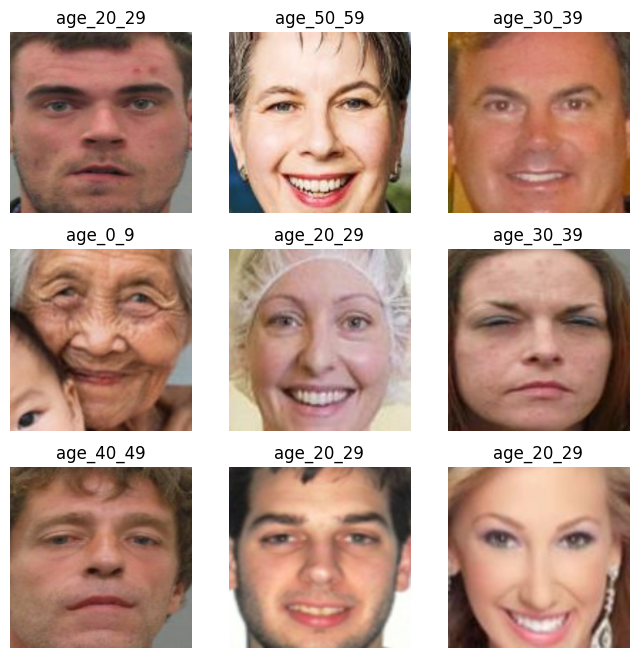

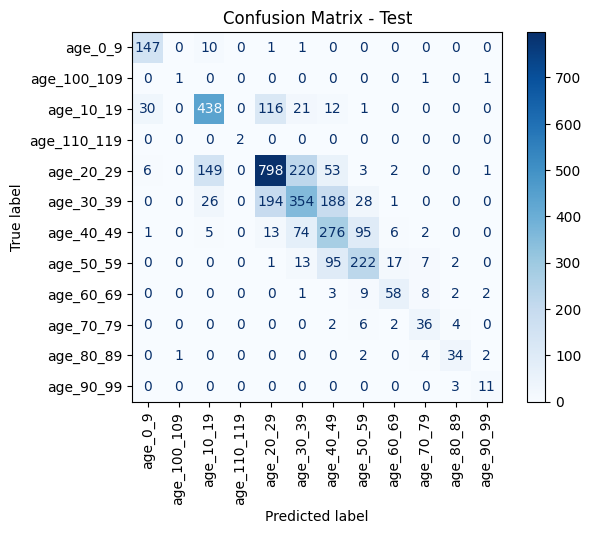


Clasificación detallada (test):
              precision    recall  f1-score   support

     age_0_9       0.80      0.92      0.86       159
 age_100_109       0.50      0.33      0.40         3
   age_10_19       0.70      0.71      0.70       618
 age_110_119       1.00      1.00      1.00         2
   age_20_29       0.71      0.65      0.68      1232
   age_30_39       0.52      0.45      0.48       791
   age_40_49       0.44      0.58      0.50       472
   age_50_59       0.61      0.62      0.61       357
   age_60_69       0.67      0.70      0.69        83
   age_70_79       0.62      0.72      0.67        50
   age_80_89       0.76      0.79      0.77        43
   age_90_99       0.65      0.79      0.71        14

    accuracy                           0.62      3824
   macro avg       0.66      0.69      0.67      3824
weighted avg       0.63      0.62      0.62      3824


🔍 Evaluación en el conjunto de prueba (test):


c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\Javi\anaconda3\envs\TFM\lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Test Loss: 0.9083, Test Accuracy: 0.6216


IndexError: list index out of range

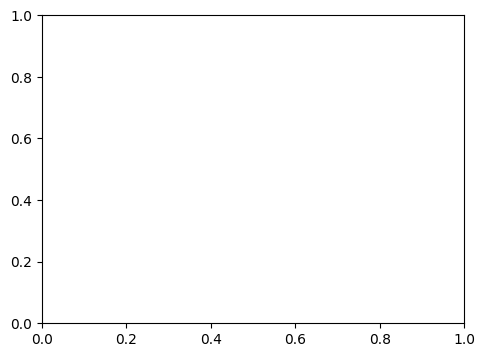

In [2]:
from fastai.vision.all import *
from sklearn.metrics import (mean_absolute_error, confusion_matrix, 
                             classification_report, balanced_accuracy_score, 
                             cohen_kappa_score, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

# ===== PARÁMETROS =====
DATASET_PATH = Path('dataset_rangos_10_split')  # Ruta de tu dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ===== CONFIGURAR DATALOADERS =====
splitter = GrandparentSplitter(train_name='train', valid_name='valid')

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=splitter,
    get_y=parent_label,
    item_tfms=Resize(IMG_SIZE)
)

dls = dblock.dataloaders(DATASET_PATH, bs=BATCH_SIZE, num_workers=0)

# Mostrar algunas imágenes para verificar la carga
dls.show_batch(max_n=9, figsize=(8, 8))

# ===== CARGAR MODELO GUARDADO =====
learn = vision_learner(
    dls,
    arch=models.efficientnet_b5,
    metrics=[accuracy],
    loss_func=CrossEntropyLossFlat()
).to_fp16()

# Cargar el modelo guardado (ajusta el nombre si es diferente)
learn.load('best_model_b5_v2')

# ===== CREAR DATA LOADER PARA TEST =====
test_files = get_image_files(DATASET_PATH / 'test')
test_dl = dls.test_dl(test_files, with_labels=True)  # Asegúrate de incluir etiquetas

# ===== OBTENER PREDICCIONES =====
preds, targs = learn.get_preds(dl=test_dl)

if targs is not None:  # Si hay etiquetas en el conjunto de test
    pred_labels = preds.argmax(dim=1)

    # ===== MÉTRICAS =====
    # Precisión
    acc = (pred_labels == targs).float().mean()
    print(f"Test Accuracy: {acc:.4f}")

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(targs, pred_labels)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(targs, pred_labels)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Cohen's Kappa
    kappa = cohen_kappa_score(targs, pred_labels)
    print(f"Cohen's Kappa: {kappa:.4f}")

    # Matriz de confusión
    cm = confusion_matrix(targs, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix - Test')
    plt.show()

    # Clasificación detallada
    print("\nClasificación detallada (test):")
    print(classification_report(targs, pred_labels, target_names=dls.vocab))
else:  # Si no hay etiquetas, solo generar predicciones
    print("El conjunto de test no tiene etiquetas. Solo se generan predicciones.")
    print(preds)

# ===== EVALUACIÓN FINAL =====
print("\n🔍 Evaluación en el conjunto de prueba (test):")
test_loss, test_accuracy = learn.validate(dl=test_dl)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# ===== GRAFICAR MÉTRICAS =====
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(L(learn.recorder.values).itemgot(2), label='Train Accuracy')
plt.plot(L(learn.recorder.values).itemgot(3), label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(L(learn.recorder.values).itemgot(0), label='Train Loss')
plt.plot(L(learn.recorder.values).itemgot(1), label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
